<a href="https://colab.research.google.com/github/DoItSon/playdata/blob/main/baseline_test_%EC%9A%A9%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 층화추출하고, 결측치 자세히 채우고, 바이너리로 올렸다.
- 점수: 0.77484

- category_encoders 설치

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 구글드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 경로및 시드고정

In [ ]:
DATA_PATH = "/content/drive/MyDrive/data/"
SEED = 42

# 라이브러리 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectPercentile

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 데이터 불러오기

In [ ]:
trans_train = pd.read_csv(f"{DATA_PATH}trans_train.csv")
ft_train = pd.read_csv(f"{DATA_PATH}백화점목표0.8/DATA/features_v6_test4.csv") # 학습데이터 정답
trans_test = pd.read_csv(f"{DATA_PATH}백화점목표0.8/DATA/ft_test_v6_test4.csv") # 테스트 데이터
sample_submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv") # 제출파일

In [ ]:
ft_train.shape, trans_test.shape

((2554, 433), (946, 432))

In [ ]:
trans_test.select_dtypes("object").nunique()

주구매지점      22
주구매중분류    132
주구매대분류     36
가구수         2
사는지역        2
dtype: int64

# 결측치 채우기

In [ ]:
ft_train["최소구매액"] = ft_train["최소구매액"].fillna(ft_train["최소구매액"].min())
ft_train["구매금액표준편차"] = ft_train["구매금액표준편차"].fillna(ft_train["구매금액표준편차"].mean())
ft_train = ft_train.fillna(0)
ft_train.isnull().sum().sum()

0

In [ ]:
trans_test["최소구매액"] = trans_test["최소구매액"].fillna(trans_test["최소구매액"].min())
trans_test["구매금액표준편차"] = trans_test["구매금액표준편차"].fillna(trans_test["구매금액표준편차"].mean())

trans_test = trans_test.fillna(0)
trans_test.isnull().sum().sum()

0

# 원핫 인코딩

In [ ]:
cols = ["주구매지점","주구매대분류","가구수","사는지역"]
enc = ce.one_hot.OneHotEncoder() 

ft_train = pd.concat([
    ft_train,
    enc.fit_transform(ft_train[cols])
],axis=1).drop(columns=cols)

trans_test = pd.concat([
    trans_test,
    enc.transform(trans_test[cols])
],axis=1).drop(columns=cols)

# 바이너리 인코딩

In [ ]:
import category_encoders as ce

enc = ce.binary.BinaryEncoder(handle_unknown='ignore') 

ft_train = pd.concat([
    ft_train,
    enc.fit_transform(ft_train["주구매중분류"])
],axis=1).drop(columns="주구매중분류")

trans_test = pd.concat([
    trans_test,
    enc.transform(trans_test["주구매중분류"])
],axis=1).drop(columns="주구매중분류")

In [ ]:
trans_test.isnull().sum()

고객번호         0
내점일수         0
구매주기         0
주말방문비율       0
주구매요일        0
            ..
주구매중분류_3    18
주구매중분류_4    18
주구매중분류_5    18
주구매중분류_6    18
주구매중분류_7    18
Length: 503, dtype: int64

In [ ]:
ft_train = ft_train.fillna(0)
trans_test = trans_test.fillna(0)

In [ ]:
ft_train.isnull().sum().sum(), trans_test.isnull().sum().sum()

(0, 0)

# 학습 데이터 , 정답 데이터, 테스트 데이터 

In [ ]:
train = ft_train.iloc[:,2:]
target = ft_train.iloc[:,1]

test = trans_test.iloc[:,1:]

# 스케일링

In [ ]:
# (array([647]), array([393])) # inf 값 처리
from numpy import inf

train = train.replace(inf,1)
test = test.replace(inf,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)

# cv 객체

In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=SEED)

# 특성 선택

In [ ]:
cv_scores = [] 
for p in tqdm(range(5,96,1)): 
    select = SelectPercentile(percentile=p)   
    select.fit(train,target) 
    model = LogisticRegression(random_state=SEED) 
    scores = cross_val_score(model,select.transform(train),target,cv = cv ,scoring='roc_auc',n_jobs = -1)
    cv_scores.append( [p,scores.mean()] ) 

cv_scores = np.array(cv_scores)
idx = np.argmax(cv_scores[:,1])
best_score = cv_scores[idx]
best_score

  0%|          | 0/91 [00:00<?, ?it/s]

array([50.        ,  0.73663135])

# 시각화

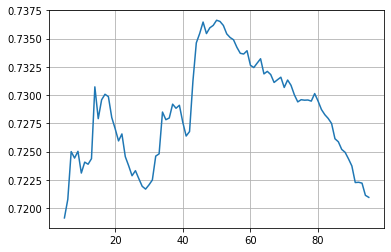

In [ ]:
plt.plot(cv_scores[:,0],cv_scores[:,1])
plt.grid()
plt.show()

# 최적의 특성들만 선택

In [ ]:
select = SelectPercentile(percentile=best_score[0])
select.fit(train,target)
train = select.transform(train)
test = select.transform(test)
train.shape , test.shape

((2554, 251), (946, 251))

# cv 검증 결과 확인하기

In [ ]:
model_list = [
    XGBClassifier(random_state=SEED), 
    LogisticRegression(random_state=SEED),
    RandomForestClassifier(random_state=SEED),
    MLPClassifier(random_state=SEED),
    LGBMClassifier(random_state=SEED)
]

for model in tqdm(model_list):
    scores = cross_val_score(model,train,target,cv = cv ,scoring='roc_auc')
    print(scores.mean())

  0%|          | 0/5 [00:00<?, ?it/s]

0.7562360837842268


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.736631353500574
0.7399896960567306


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

0.7077550520577145
0.7448769675356617


# 모델 학습후 예측하기

In [ ]:
pred_list = []
for model in tqdm(model_list):
    model.fit(train,target)
    pred = model.predict_proba(test)[:,1]
    pred_list.append(pred)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


# 산술평균 앙상블

In [ ]:
# 모델 앙상블 전
pred = np.mean(pred_list,axis=0)
pred.shape

(946,)

# 제출파일에 예측 확률 넣기

In [ ]:
sample_submission["target"] = pred
sample_submission

,고객번호,target
0,10001,0.373300
1,10070,0.272313
2,10075,0.269123
3,10086,0.346826
4,10128,0.462030
...,...,...
941,49903,0.271690
942,49918,0.103795
943,49937,0.537091
944,49949,0.150477


# 제출 파일 저장

In [ ]:
sample_submission.to_csv("submit.csv",index=False)